In [1]:
# kiểm tra GPU
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15051238987174952812
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5767102464
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9933348564481151500
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [2]:
!nvidia-smi

Mon Nov  8 02:24:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.49       Driver Version: 496.49       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   42C    P2    32W / 240W |   1489MiB /  8192MiB |      9%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Khởi tạo môi trường
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data = pd.read_csv('LDS8_DeThi_k270\Dataset\MELBOURNE_HOUSE_PRICES_LESS.csv')
print(data.shape)
data.head()

(63023, 13)


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Postcode,Regionname,Propertycount,Distance,CouncilArea
0,Abbotsford,49 Lithgow St,3,h,1490000.0,S,Jellis,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council
1,Abbotsford,59A Turner St,3,h,1220000.0,S,Marshall,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council
2,Abbotsford,119B Yarra St,3,h,1420000.0,S,Nelson,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council
3,Aberfeldie,68 Vida St,3,h,1515000.0,S,Barry,1/04/2017,3040,Western Metropolitan,1543,7.5,Moonee Valley City Council
4,Airport West,92 Clydesdale Rd,2,h,670000.0,S,Nelson,1/04/2017,3042,Western Metropolitan,3464,10.4,Moonee Valley City Council


<h2>Features of the dataset</h2>

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63023 entries, 0 to 63022
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         63023 non-null  object 
 1   Address        63023 non-null  object 
 2   Rooms          63023 non-null  int64  
 3   Type           63023 non-null  object 
 4   Price          48433 non-null  float64
 5   Method         63023 non-null  object 
 6   SellerG        63023 non-null  object 
 7   Date           63023 non-null  object 
 8   Postcode       63023 non-null  int64  
 9   Regionname     63023 non-null  object 
 10  Propertycount  63023 non-null  int64  
 11  Distance       63023 non-null  float64
 12  CouncilArea    63023 non-null  object 
dtypes: float64(2), int64(3), object(8)
memory usage: 6.3+ MB


In [6]:
data.describe()

,Rooms,Price,Postcode,Propertycount,Distance
count,63023.000000,4.843300e+04,63023.000000,63023.000000,63023.000000
mean,3.110595,9.978982e+05,3125.673897,7617.728131,12.684829
std,0.957551,5.934989e+05,125.626877,4424.423167,7.592015
min,1.000000,8.500000e+04,3000.000000,39.000000,0.000000
25%,3.000000,6.200000e+05,3056.000000,4380.000000,7.000000
50%,3.000000,8.300000e+05,3107.000000,6795.000000,11.400000
75%,4.000000,1.220000e+06,3163.000000,10412.000000,16.700000
max,31.000000,1.120000e+07,3980.000000,21650.000000,64.100000


In [7]:
print('Categorical Features ')
print(data.select_dtypes(['object']).columns)
print('\nNumeric Features')
print(data.select_dtypes(['int64','float64']).columns)

Categorical Features 
Index(['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Date', 'Regionname',
       'CouncilArea'],
      dtype='object')

Numeric Features
Index(['Rooms', 'Price', 'Postcode', 'Propertycount', 'Distance'], dtype='object')


<h2>Cleaning Data</h2>
<h3>Xóa các cột không có ý nghĩa</h3>
<p>Cột Address,SellerG, Property Count sẽ bị bỏ vì các cột đó không có giá trị phân tích</p>

In [8]:
data = data.drop(['Propertycount','SellerG','Address'], axis = 1)

In [9]:
data['Date'] = pd.to_datetime(data['Date'])
data['Month'] = data['Date'].apply(lambda date:date.month)
data['Year'] = data['Date'].apply(lambda date:date.year)
data['Day'] = data['Date'].apply(lambda date:date.day)

In [10]:
data.isnull().sum()

Suburb             0
Rooms              0
Type               0
Price          14590
Method             0
Date               0
Postcode           0
Regionname         0
Distance           0
CouncilArea        0
Month              0
Year               0
Day                0
dtype: int64

<h3>Nhận xét:</h3>
<p>Có 2 cách để làm mất Nan trong cột Prices:</p>
<ol>
    <li>Thay Nan bằng mean để không thay đổi mean của toàn bộ cột </li>
    <li>Xóa các hàng có giá trị Nan </li> 
</ol>
<strong>Do dữ liệu khá nhiều và chỉ có cột Price có giá trị Nan nên sẽ xóa các hàng chứa giá trị Nan</strong>

In [11]:
NonPricing_data = data[data['Price'].isna()]

In [12]:
NonPricing_data.shape

(14590, 13)

In [13]:
NonNan_data = data.dropna(axis=0)

In [14]:
NonNan_data.isnull().sum()

Suburb         0
Rooms          0
Type           0
Price          0
Method         0
Date           0
Postcode       0
Regionname     0
Distance       0
CouncilArea    0
Month          0
Year           0
Day            0
dtype: int64

<h2>Data Visualization</h2>

C:\Users\Admins\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Price'>

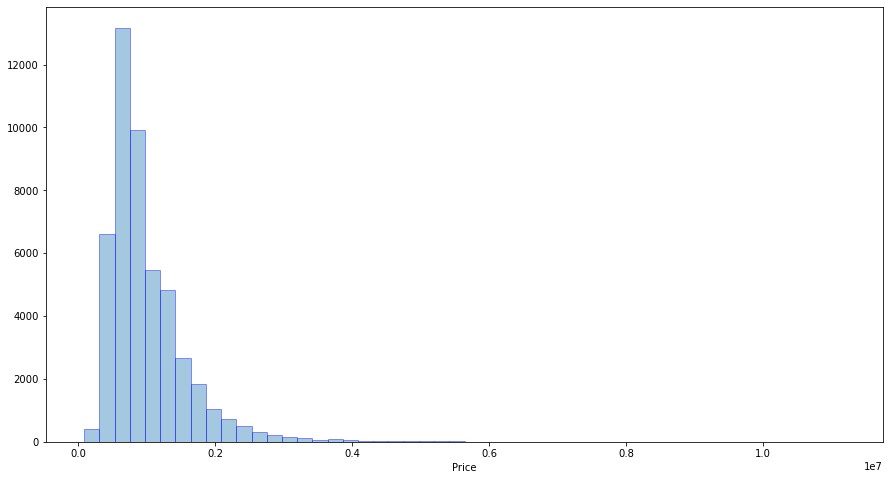

In [15]:
plt.figure(figsize=(15,8))
sns.distplot(NonNan_data['Price'], kde = False,hist_kws=dict(edgecolor="b"))

Text(0.5, 1.0, 'Method vs Price')

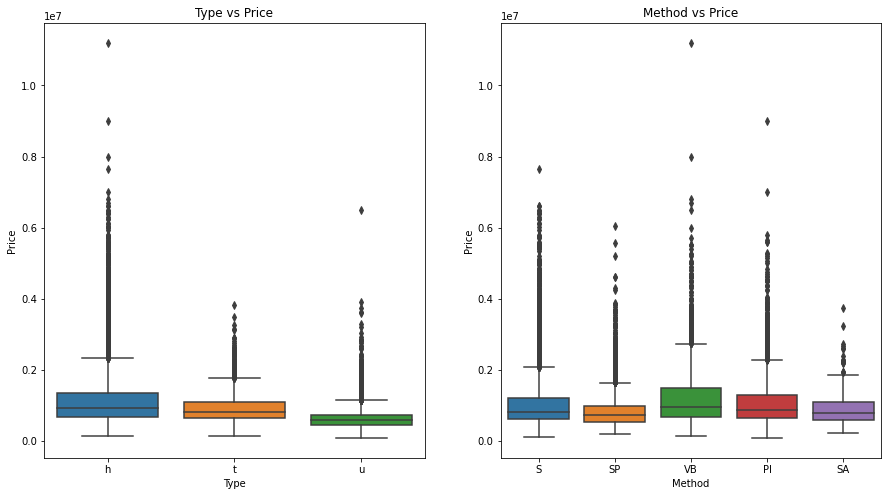

In [16]:
plt.figure(figsize =(15,8))

ax1 = plt.subplot(1,2,1)
sns.boxplot(data=NonNan_data, x='Type', y='Price')
ax1.set_xlabel('Type')
ax1.set_ylabel('Price')
ax1.set_title('Type vs Price')

ax2 = plt.subplot(1,2,2,sharey=ax1)
sns.boxplot(data=NonNan_data, x='Method', y='Price')
ax2.set_xlabel('Method')
ax2.set_ylabel('Price')
ax2.set_title('Method vs Price')

<AxesSubplot:xlabel='Year'>

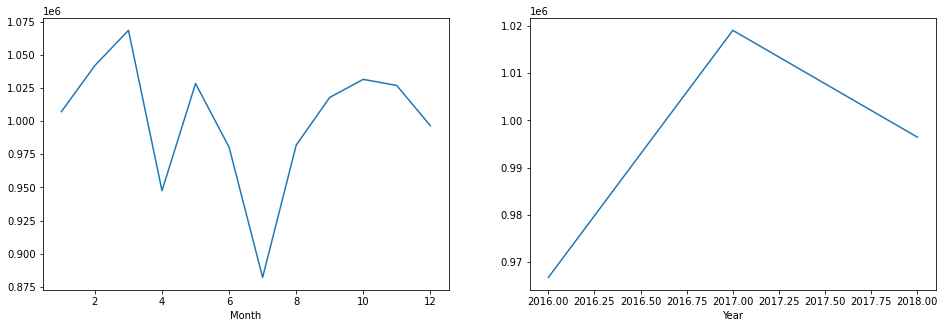

In [17]:
#data visualization house price vs months and years
fig = plt.figure(figsize=(16,5))
fig.add_subplot(1,2,1)
NonNan_data.groupby('Month').mean()['Price'].plot()
fig.add_subplot(1,2,2)
NonNan_data.groupby('Year').mean()['Price'].plot()

<AxesSubplot:xlabel='Day'>

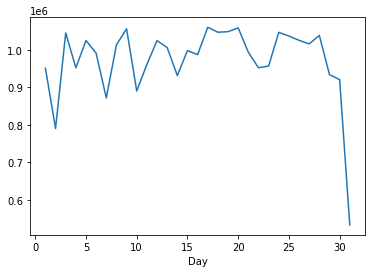

In [18]:
NonNan_data.groupby('Day').mean()['Price'].plot()

<h3>Nhận xét</h3>
<li>Cột Rooms có hệ số corr cao nhất</li>
<li>Cột Postcode có hệ số corr thấp nhất</li>
<li>Tháng 3 giá nhà có mức trung bình cao nhất và tháng 7 giá nhà có mức trung bình thấp nhất</li>
<li>Từ 2016 đến 2017 thì giá nhà tăng, sau 2017 giá nhà giảm tuyến tính</li>

<h2>Preprocessing Data</h2>

In [19]:
def preprocessing(data):
    new_data = data[data.columns]
    new_data.drop(['Date','Suburb','Postcode','Day'],axis = 1, inplace = True)
    one_hot_encode_cols = new_data.dtypes[new_data.dtypes ==np.object]
    one_hot_encode_cols = one_hot_encode_cols.index.tolist()
    new_data = pd.get_dummies(new_data, columns = one_hot_encode_cols, drop_first = True)
    return new_data
def preprocessing_Newinput(new_input):
    new_input = preprocessing(new_input)
    final_Newinput = s_scaler.transform(new_input.astype(np.float))
    return final_Newinput

In [20]:
NonPricing_data = preprocessing(NonPricing_data)
NonNan_data = preprocessing(NonNan_data)

In [21]:
[x for x in NonPricing_data.columns if x not in NonNan_data.columns]

['Method_PN', 'Method_SN', 'Method_SS', 'Method_W']

<h3>Nhận xét</h3>
<p> Ở cột Method có các phân loại mà NonPricing_data(data cột target là nan) có nhưng NonNan_data (data sau khi drop nan)</p>
<p> Do đó ta sẽ encoder các cột phân loại trước xong mới drop nan value</p>

In [22]:
data = preprocessing(data)

In [23]:
new_data = data[data['Price'].isna()] # dữ liệu có cột price là nan

In [24]:
data = data.dropna(axis=0)

In [25]:
data.isnull().sum()

Rooms                                         0
Price                                         0
Distance                                      0
Month                                         0
Year                                          0
Type_t                                        0
Type_u                                        0
Method_PN                                     0
Method_S                                      0
Method_SA                                     0
Method_SN                                     0
Method_SP                                     0
Method_SS                                     0
Method_VB                                     0
Method_W                                      0
Regionname_Eastern Victoria                   0
Regionname_Northern Metropolitan              0
Regionname_Northern Victoria                  0
Regionname_South-Eastern Metropolitan         0
Regionname_Southern Metropolitan              0
Regionname_Western Metropolitan         

<h2>Outliers</h2>

<AxesSubplot:ylabel='Price'>

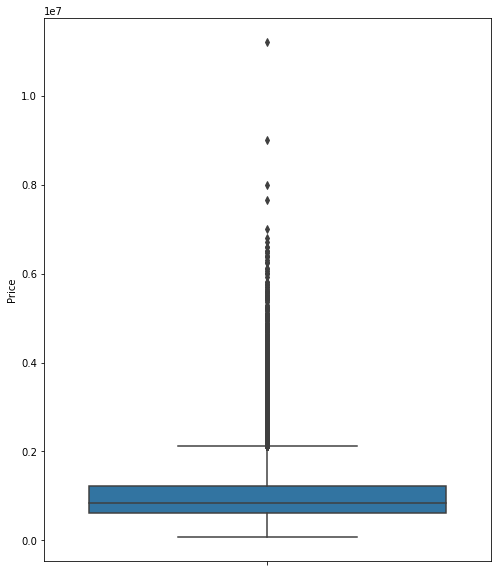

In [26]:
plt.figure(figsize=(8,10))
sns.boxplot(data = data, y='Price')

In [27]:
from scipy.stats import iqr
IQR = iqr(np.array(data.Price),axis = 0)
IQR

600000.0

In [28]:
Q1 = data.Price.quantile(0.25)
Q3 = data.Price.quantile(0.75)
print('Q1 = ',Q1,' || Q3 = ',Q3)

Q1 =  620000.0  || Q3 =  1220000.0


In [29]:
upper_boundary = Q3 + 1.5*IQR
lower_boundary = Q1 - 1.5*IQR
print('upper_boundary = ',upper_boundary,' || lower_boundary = ',lower_boundary)

upper_boundary =  2120000.0  || lower_boundary =  -280000.0


In [30]:
data2=data[~((data.Price<(Q1-1.5*IQR)) | (data.Price>(Q3+1.5*IQR)))]

In [31]:
data2 

,Rooms,Price,Distance,Month,Year,Type_t,Type_u,Method_PN,Method_S,Method_SA,...,CouncilArea_Moreland City Council,CouncilArea_Murrindindi Shire Council,CouncilArea_Nillumbik Shire Council,CouncilArea_Port Phillip City Council,CouncilArea_Stonnington City Council,CouncilArea_Whitehorse City Council,CouncilArea_Whittlesea City Council,CouncilArea_Wyndham City Council,CouncilArea_Yarra City Council,CouncilArea_Yarra Ranges Shire Council
0,3,1490000.0,3.0,1,2017,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,3,1220000.0,3.0,1,2017,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,3,1420000.0,3.0,1,2017,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,3,1515000.0,7.5,1,2017,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,2,670000.0,10.4,1,2017,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63016,2,347700.0,38.0,3,2018,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
63017,3,808000.0,8.4,3,2018,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
63018,3,566000.0,20.6,3,2018,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
63019,3,500000.0,20.6,3,2018,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:ylabel='Price'>

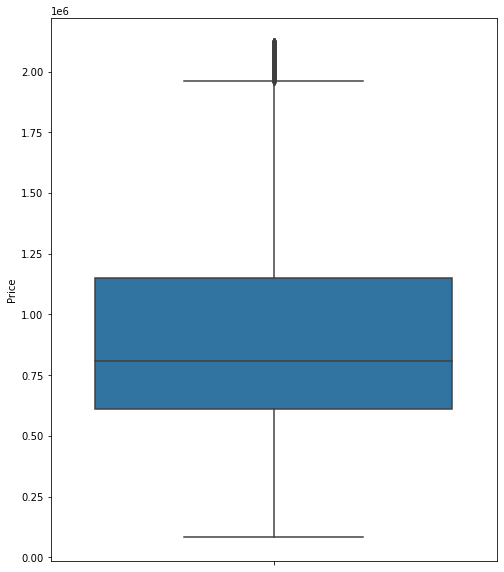

In [32]:
plt.figure(figsize=(8,10))
sns.boxplot(data = data2, y='Price')

<h2>Scaling data</h2>

In [33]:
data2.describe() # Price có giá trị quá lớn so với các giá trị còn lại
data2.loc[:,'Price_div_10e6'] = data2['Price']/10**6

C:\Users\Admins\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\Admins\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [34]:
data2.describe()

,Rooms,Price,Distance,Month,Year,Type_t,Type_u,Method_PN,Method_S,Method_SA,...,CouncilArea_Murrindindi Shire Council,CouncilArea_Nillumbik Shire Council,CouncilArea_Port Phillip City Council,CouncilArea_Stonnington City Council,CouncilArea_Whitehorse City Council,CouncilArea_Whittlesea City Council,CouncilArea_Wyndham City Council,CouncilArea_Yarra City Council,CouncilArea_Yarra Ranges Shire Council,Price_div_10e6
count,46161.000000,4.616100e+04,46161.000000,46161.00000,46161.000000,46161.000000,46161.000000,46161.0,46161.000000,46161.000000,...,46161.000000,46161.000000,46161.000000,46161.000000,46161.000000,46161.000000,46161.000000,46161.000000,46161.000000,46161.000000
mean,3.022811,9.064885e+05,12.929012,6.87145,2017.041139,0.106800,0.200559,0.0,0.636251,0.007604,...,0.000022,0.005134,0.025216,0.020602,0.028119,0.044605,0.024999,0.027404,0.003791,0.906489
std,0.917467,3.977061e+05,7.606447,3.06637,0.762176,0.308862,0.400423,0.0,0.481083,0.086869,...,0.004654,0.071470,0.156783,0.142049,0.165315,0.206437,0.156125,0.163260,0.061456,0.397706
min,1.000000,8.500000e+04,0.000000,1.00000,2016.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.085000
25%,2.000000,6.100000e+05,7.200000,4.00000,2016.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.610000
50%,3.000000,8.100000e+05,12.000000,7.00000,2017.000000,0.000000,0.000000,0.0,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.810000
75%,4.000000,1.150000e+06,17.200000,9.00000,2018.000000,0.000000,0.000000,0.0,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.150000
max,31.000000,2.120000e+06,55.800000,12.00000,2018.000000,1.000000,1.000000,0.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.120000


In [35]:
X = data2.drop(['Price','Price_div_10e6'], axis=1)
y = data2['Price_div_10e6']
X.head()

,Rooms,Distance,Month,Year,Type_t,Type_u,Method_PN,Method_S,Method_SA,Method_SN,...,CouncilArea_Moreland City Council,CouncilArea_Murrindindi Shire Council,CouncilArea_Nillumbik Shire Council,CouncilArea_Port Phillip City Council,CouncilArea_Stonnington City Council,CouncilArea_Whitehorse City Council,CouncilArea_Whittlesea City Council,CouncilArea_Wyndham City Council,CouncilArea_Yarra City Council,CouncilArea_Yarra Ranges Shire Council
0,3,3.0,1,2017,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,3,3.0,1,2017,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,3,3.0,1,2017,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,3,7.5,1,2017,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,10.4,1,2017,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


C:\Users\Admins\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Price_div_10e6', ylabel='Density'>

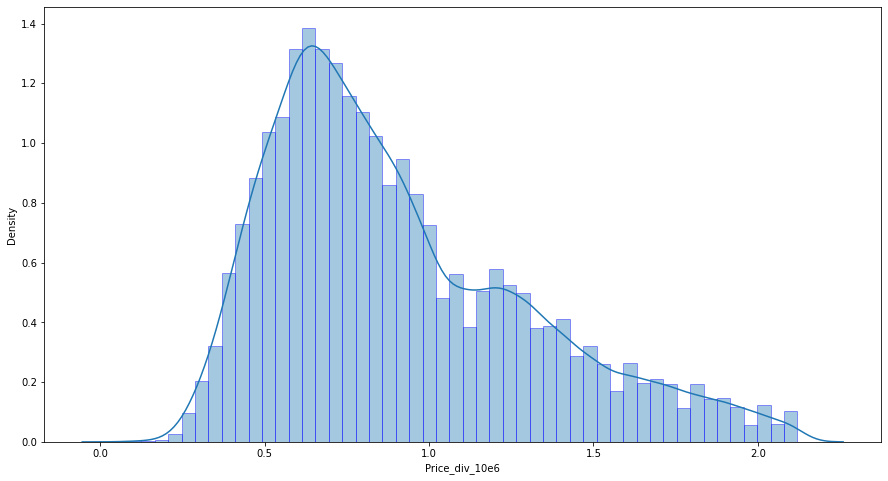

In [36]:
plt.figure(figsize=(15,8))
sns.distplot(y, kde = True,hist_kws=dict(edgecolor="b"))

In [37]:
#standardization scaler - fit&transform on train, fit only on test
from sklearn.preprocessing import StandardScaler
s_scaler = StandardScaler()
X = s_scaler.fit_transform(X.astype(np.float))

<h2>Split Data</h2>

In [38]:
#import regression libraries
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split

In [39]:
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.3,random_state=42)

In [40]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train,test_size=0.2,random_state=12)

In [41]:
print('Train shape: ',X_train.shape)
print('Valid shape: ',X_valid.shape)
print('Test shape: ',X_test.shape)

Train shape:  (25849, 54)
Valid shape:  (13849, 54)
Test shape:  (6463, 54)


<h2>Training and Evaluation Model</h2>
<h3>Model1</h3>

In [42]:
# Creating a Neural Network Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint, ReduceLROnPlateau

In [43]:
# having 19 neuron is based on the number of available features
model = Sequential()
model.add(Dense(50,input_dim=54, kernel_initializer='normal',activation='relu'))
model.add(Dense(30,activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dense(10,activation='relu'))
model.add(Dense(1,activation='linear'))
model.compile(optimizer='Adam',loss='mse',metrics=['mae','mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                2750      
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                496       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                170       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 4,957
Trainable params: 4,957
Non-trainable params: 0
_________________________________________________________________


In [44]:
checkpoint = ModelCheckpoint('./checkpoint/Ex1/Model1.h5',monitor='val_loss',save_best_only=True,save_weights_only=True,mode='min')
learning_rate = ReduceLROnPlateau(patience=5,verbose=1,factor=0.5,min_delta=0.000001)
early_stopping = EarlyStopping(patience=30,monitor='val_loss',verbose=1,restore_best_weights=True,mode='min')

In [45]:
import time
pre_train1 = time.time()
history = model.fit(X_train,y_train,validation_data=(X_valid,y_valid),
                    epochs=500,batch_size = 64,callbacks=[early_stopping,learning_rate,checkpoint])
time_training1 = time.time() - pre_train1

Epoch 1/500
404/404 [==============================] - 3s 5ms/step - loss: 0.0788 - mae: 0.1952 - mse: 0.0788 - val_loss: 0.0498 - val_mae: 0.1610 - val_mse: 0.0498
Epoch 2/500
404/404 [==============================] - 2s 5ms/step - loss: 0.0492 - mae: 0.1606 - mse: 0.0492 - val_loss: 0.0489 - val_mae: 0.1579 - val_mse: 0.0489
Epoch 3/500
404/404 [==============================] - 2s 5ms/step - loss: 0.0475 - mae: 0.1574 - mse: 0.0475 - val_loss: 0.0476 - val_mae: 0.1541 - val_mse: 0.0476
Epoch 4/500
404/404 [==============================] - 2s 5ms/step - loss: 0.0464 - mae: 0.1559 - mse: 0.0464 - val_loss: 0.0471 - val_mae: 0.1564 - val_mse: 0.0471
Epoch 5/500
404/404 [==============================] - 2s 5ms/step - loss: 0.0456 - mae: 0.1538 - mse: 0.0456 - val_loss: 0.0467 - val_mae: 0.1564 - val_mse: 0.0467
Epoch 6/500
404/404 [==============================] - 2s 5ms/step - loss: 0.0450 - mae: 0.1529 - mse: 0.0450 - val_loss: 0.0467 - val_mae: 0.1553 - val_mse: 0.0467
Epoch 7/50

404/404 [==============================] - 2s 6ms/step - loss: 0.0374 - mae: 0.1381 - mse: 0.0374 - val_loss: 0.0437 - val_mae: 0.1478 - val_mse: 0.0437
Epoch 49/500
404/404 [==============================] - 2s 5ms/step - loss: 0.0374 - mae: 0.1381 - mse: 0.0374 - val_loss: 0.0437 - val_mae: 0.1483 - val_mse: 0.0437
Epoch 50/500
404/404 [==============================] - 2s 5ms/step - loss: 0.0373 - mae: 0.1381 - mse: 0.0373 - val_loss: 0.0437 - val_mae: 0.1483 - val_mse: 0.0437
Epoch 51/500
404/404 [==============================] - 2s 5ms/step - loss: 0.0373 - mae: 0.1380 - mse: 0.0373 - val_loss: 0.0438 - val_mae: 0.1493 - val_mse: 0.0438

Epoch 00051: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 52/500
404/404 [==============================] - 2s 5ms/step - loss: 0.0372 - mae: 0.1378 - mse: 0.0372 - val_loss: 0.0438 - val_mae: 0.1487 - val_mse: 0.0438
Epoch 53/500
404/404 [==============================] - 2s 5ms/step - loss: 0.0372 - mae: 0.1378 - mse

In [46]:
print('Time training model1: %.1f (s)'%(time_training1))

Time training model1: 159.8 (s)


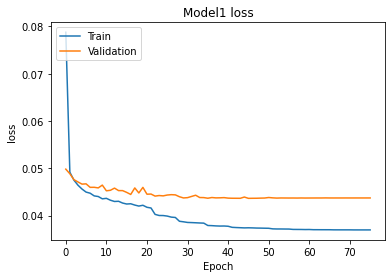

In [47]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model1 loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'],loc='upper left')
plt.show()

In [48]:
scores1 = model.evaluate(X_test,y_test)
scores1

202/202 [==============================] - 0s 2ms/step - loss: 0.0438 - mae: 0.1488 - mse: 0.0438


[0.04376937821507454, 0.14878897368907928, 0.04376937821507454]

<h3>Model2</h3>

In [50]:
# model2
# having 19 neuron is based on the number of available features
model2 = Sequential()
model2.add(Dense(27,input_dim=54, kernel_initializer='normal',activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(20,activation='relu'))
model2.add(Dense(15,activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(10,activation='relu'))
model2.add(Dense(1,activation='linear'))
model2.compile(optimizer='Adam',loss='mse',metrics=['mae','mse'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 27)                1485      
_________________________________________________________________
dropout_2 (Dropout)          (None, 27)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 20)                560       
_________________________________________________________________
dense_12 (Dense)             (None, 15)                315       
_________________________________________________________________
dropout_3 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                160       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                

In [51]:
checkpoint2 = ModelCheckpoint('./checkpoint/Ex1/Model2.h5',monitor='val_loss',save_best_only=True,save_weights_only=True,mode='min')
learning_rate2 = ReduceLROnPlateau(patience=5,verbose=1,factor=0.5,min_delta=0.000001)
early_stopping2 = EarlyStopping(patience=30,monitor='val_loss',verbose=1,restore_best_weights=True,mode='min')

In [53]:
pre_train = time.time()
history2 = model2.fit(X_train,y_train,validation_data=(X_valid,y_valid),
                    epochs=500,batch_size = 64,callbacks=[early_stopping2,learning_rate2,checkpoint2])
time_training2 = time.time() - pre_train

Epoch 1/500
404/404 [==============================] - 3s 6ms/step - loss: 0.1533 - mae: 0.2832 - mse: 0.1533 - val_loss: 0.0639 - val_mae: 0.1785 - val_mse: 0.0639
Epoch 2/500
404/404 [==============================] - 2s 5ms/step - loss: 0.0761 - mae: 0.2002 - mse: 0.0761 - val_loss: 0.0598 - val_mae: 0.1726 - val_mse: 0.0598
Epoch 3/500
404/404 [==============================] - 2s 5ms/step - loss: 0.0648 - mae: 0.1856 - mse: 0.0648 - val_loss: 0.0586 - val_mae: 0.1746 - val_mse: 0.0586
Epoch 4/500
404/404 [==============================] - 2s 5ms/step - loss: 0.0607 - mae: 0.1796 - mse: 0.0607 - val_loss: 0.0536 - val_mae: 0.1688 - val_mse: 0.0536
Epoch 5/500
404/404 [==============================] - 2s 5ms/step - loss: 0.0595 - mae: 0.1771 - mse: 0.0595 - val_loss: 0.0549 - val_mae: 0.1700 - val_mse: 0.0549
Epoch 6/500
404/404 [==============================] - 2s 6ms/step - loss: 0.0563 - mae: 0.1743 - mse: 0.0563 - val_loss: 0.0528 - val_mae: 0.1683 - val_mse: 0.0528
Epoch 7/50

In [54]:
print('Time training model1: %.1f (s)'%(time_training2))

Time training model1: 90.8 (s)


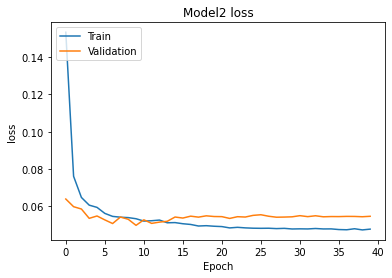

In [55]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model2 loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'],loc='upper left')
plt.show()

In [56]:
scores2 = model2.evaluate(X_test,y_test)
scores2

202/202 [==============================] - 0s 2ms/step - loss: 0.1008 - mae: 0.1668 - mse: 0.1008


[0.10083014518022537, 0.166776642203331, 0.10083014518022537]

<h3>Model3</h3>

In [57]:
# model2
# having 19 neuron is based on the number of available features
model3 = Sequential()
model3.add(Dense(54,input_dim=54, kernel_initializer='normal',activation='relu'))
model3.add(Dropout(0.3))
model3.add(Dense(34,activation='relu'))
model3.add(Dense(25,activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(15,activation='relu'))
model3.add(Dense(5,activation='relu'))
model3.add(Dense(1,activation='linear'))
model3.compile(optimizer='Adam',loss='mse',metrics=['mae','mse'])
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 54)                2970      
_________________________________________________________________
dropout_4 (Dropout)          (None, 54)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 34)                1870      
_________________________________________________________________
dense_17 (Dense)             (None, 25)                875       
_________________________________________________________________
dropout_5 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 15)                390       
_________________________________________________________________
dense_19 (Dense)             (None, 5)                

In [58]:
checkpoint3 = ModelCheckpoint('./checkpoint/Ex1/Model3.h5',monitor='val_loss',save_best_only=True,save_weights_only=True,mode='min')
learning_rate3 = ReduceLROnPlateau(patience=5,verbose=1,factor=0.5,min_delta=0.000001)
early_stopping3 = EarlyStopping(patience=30,monitor='val_loss',verbose=1,restore_best_weights=True,mode='min')

In [59]:
pre_train = time.time()
history3 = model3.fit(X_train,y_train,validation_data=(X_valid,y_valid),
                    epochs=500,batch_size = 64,callbacks=[early_stopping3,learning_rate3,checkpoint3])
time_training3 = time.time() - pre_train

Epoch 1/500
404/404 [==============================] - 3s 7ms/step - loss: 0.1301 - mae: 0.2539 - mse: 0.1301 - val_loss: 0.0551 - val_mae: 0.1683 - val_mse: 0.0551
Epoch 2/500
404/404 [==============================] - 2s 6ms/step - loss: 0.0619 - mae: 0.1814 - mse: 0.0619 - val_loss: 0.0503 - val_mae: 0.1646 - val_mse: 0.0503
Epoch 3/500
404/404 [==============================] - 2s 6ms/step - loss: 0.0574 - mae: 0.1740 - mse: 0.0574 - val_loss: 0.0542 - val_mae: 0.1645 - val_mse: 0.0542
Epoch 4/500
404/404 [==============================] - 2s 6ms/step - loss: 0.0534 - mae: 0.1687 - mse: 0.0534 - val_loss: 0.0502 - val_mae: 0.1599 - val_mse: 0.0502
Epoch 5/500
404/404 [==============================] - 2s 6ms/step - loss: 0.0526 - mae: 0.1666 - mse: 0.0526 - val_loss: 0.0533 - val_mae: 0.1614 - val_mse: 0.0533
Epoch 6/500
404/404 [==============================] - 2s 6ms/step - loss: 0.0510 - mae: 0.1646 - mse: 0.0510 - val_loss: 0.0470 - val_mae: 0.1564 - val_mse: 0.0470
Epoch 7/50

Epoch 47/500
404/404 [==============================] - 2s 6ms/step - loss: 0.0436 - mae: 0.1506 - mse: 0.0436 - val_loss: 0.0478 - val_mae: 0.1595 - val_mse: 0.0478
Epoch 48/500
404/404 [==============================] - 2s 6ms/step - loss: 0.0435 - mae: 0.1506 - mse: 0.0435 - val_loss: 0.0479 - val_mae: 0.1596 - val_mse: 0.0479

Epoch 00048: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
Epoch 49/500
404/404 [==============================] - 2s 6ms/step - loss: 0.0432 - mae: 0.1502 - mse: 0.0432 - val_loss: 0.0478 - val_mae: 0.1594 - val_mse: 0.0478
Epoch 50/500
404/404 [==============================] - 2s 6ms/step - loss: 0.0432 - mae: 0.1501 - mse: 0.0432 - val_loss: 0.0478 - val_mae: 0.1594 - val_mse: 0.0478
Epoch 51/500
404/404 [==============================] - 2s 6ms/step - loss: 0.0432 - mae: 0.1503 - mse: 0.0432 - val_loss: 0.0479 - val_mae: 0.1596 - val_mse: 0.0479
Epoch 52/500
404/404 [==============================] - 2s 6ms/step - loss: 0.0432 - mae:

In [60]:
print('Time training model3: %.1f (s)'%(time_training3))

Time training model3: 131.7 (s)


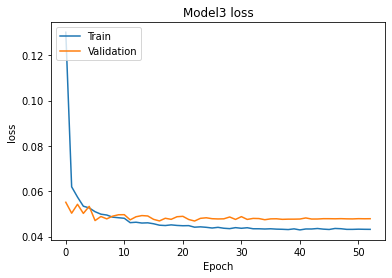

In [61]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model3 loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'],loc='upper left')
plt.show()

In [62]:
scores3 = model3.evaluate(X_test,y_test)
scores3

202/202 [==============================] - 0s 2ms/step - loss: 0.0621 - mae: 0.1595 - mse: 0.0621


[0.0620717853307724, 0.15951073169708252, 0.0620717853307724]

<h3>Nhận xét</h3>
<li>Model1 có dấu hiệu overfiting nhưng lại chạy khá tốt trên tập test</li>
<li>Model2 trong quá trình training không có dấu hiệu overfiting nhưng trong test có loss khá cao</li>
<li>Model3 hoạt động hiệu quả hơn 2 model trên trong cả 3 tập train,valid và test</li>

<h3>Dự đoán giá trị mới</h3>

In [64]:
X_new = new_data.drop(['Price'], axis=1)

In [65]:
X_new.columns

Index(['Rooms', 'Distance', 'Month', 'Year', 'Type_t', 'Type_u', 'Method_PN',
       'Method_S', 'Method_SA', 'Method_SN', 'Method_SP', 'Method_SS',
       'Method_VB', 'Method_W', 'Regionname_Eastern Victoria',
       'Regionname_Northern Metropolitan', 'Regionname_Northern Victoria',
       'Regionname_South-Eastern Metropolitan',
       'Regionname_Southern Metropolitan', 'Regionname_Western Metropolitan',
       'Regionname_Western Victoria', 'CouncilArea_Bayside City Council',
       'CouncilArea_Boroondara City Council',
       'CouncilArea_Brimbank City Council',
       'CouncilArea_Cardinia Shire Council', 'CouncilArea_Casey City Council',
       'CouncilArea_Darebin City Council',
       'CouncilArea_Frankston City Council',
       'CouncilArea_Glen Eira City Council',
       'CouncilArea_Greater Dandenong City Council',
       'CouncilArea_Hobsons Bay City Council', 'CouncilArea_Hume City Council',
       'CouncilArea_Kingston City Council', 'CouncilArea_Knox City Council',
 

In [67]:
X_new = s_scaler.transform(X_new)

In [68]:
X_new

array([[ 3.24504408,  0.14080163, -1.91480918, ..., -0.16012637,
        -0.16785777, -0.06168878],
       [ 1.0651055 ,  0.33800492, -1.91480918, ..., -0.16012637,
        -0.16785777, -0.06168878],
       [ 1.0651055 , -0.35878002, -1.91480918, ..., -0.16012637,
        -0.16785777, -0.06168878],
       ...,
       [ 1.0651055 , -0.33248625, -1.26256512, ..., -0.16012637,
        -0.16785777, -0.06168878],
       [-0.0248638 ,  0.31171114, -1.26256512, ..., -0.16012637,
        -0.16785777, -0.06168878],
       [ 1.0651055 ,  0.61408951, -1.26256512, ...,  6.24506738,
        -0.16785777, -0.06168878]])

In [69]:
y_new = model3.predict(X_new)

In [70]:
y_new

array([[0.8510285 ],
       [0.7571755 ],
       [1.5694507 ],
       ...,
       [1.3033525 ],
       [0.5502228 ],
       [0.68509203]], dtype=float32)